# Feature engineering
- Points last year
- Points jan + feb + mar
- Points apr + may
- Points jun upto TdF

- Bib number ranking within team (last number)

# TODO
Feature importance plot
Use best team selector
Per year, make comparison between best possible team and the best team selected based on prediction.
Why were the wrong riders selected?

In [1]:
from tdf_pool.race import Race
from tdf_pool.cycling_calendar import get_calendar
from tdf_pool.score import get_score_template, score_race
from tdf_pool.custom_stats import custom_f_score, custom_binary_classifications
from datetime import date
import logging
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

logging.basicConfig(level="INFO")

In [2]:
# Load data from 2014 to 2024
years = list(range(2014, 2025))
races = []
for year in years:
    calendar = get_calendar(year)
    for _, item in calendar.iterrows():
        if item['Start'] > date(2024, 7, 1):
            continue
        races.append(Race(item['Name'], item['Start'], item['Type'], item['PartialURL']))

INFO:tdf_pool.cycling_calendar:[ OK ] Read race calender of 2014
INFO:tdf_pool.stage:[ OK ] Loaded results for <Santos Tour Down Under stage 1, Nuriootpa - Angaston, Date: 2014-01-21, Type: Stage>
INFO:tdf_pool.stage:[ OK ] Loaded results for <Santos Tour Down Under stage 2, Prospect - Stirling, Date: 2014-01-22, Type: Stage>
INFO:tdf_pool.stage:[ OK ] Loaded results for <Santos Tour Down Under stage 3, Norwood - Campbelltown, Date: 2014-01-23, Type: Stage>
INFO:tdf_pool.stage:[ OK ] Loaded results for <Santos Tour Down Under stage 4, Unley - Victor Harbor, Date: 2014-01-24, Type: Stage>
INFO:tdf_pool.stage:[ OK ] Loaded results for <Santos Tour Down Under stage 5, McLaren Vale - Willunga, Date: 2014-01-25, Type: Stage>
INFO:tdf_pool.stage:[ OK ] Loaded results for <Santos Tour Down Under stage 6, Adelaide - Adelaide, Date: 2014-01-26, Type: Stage>
INFO:tdf_pool.stage:[ OK ] Loaded results for <Paris - Nice stage 1, Mantes-la-Jolie - Mantes-la-Jolie, Date: 2014-03-09, Type: Stage>
INFO

In [3]:
score_template = get_score_template()
scores = [score_race(race, score_template) for race in races]

INFO:tdf_pool.score:Scoring <Santos Tour Down Under stage 1, Nuriootpa - Angaston, Date: 2014-01-21, Type: Stage>
INFO:tdf_pool.score:Scoring <Santos Tour Down Under stage 2, Prospect - Stirling, Date: 2014-01-22, Type: Stage>
INFO:tdf_pool.score:Scoring <Santos Tour Down Under stage 3, Norwood - Campbelltown, Date: 2014-01-23, Type: Stage>
INFO:tdf_pool.score:Scoring <Santos Tour Down Under stage 4, Unley - Victor Harbor, Date: 2014-01-24, Type: Stage>
INFO:tdf_pool.score:Scoring <Santos Tour Down Under stage 5, McLaren Vale - Willunga, Date: 2014-01-25, Type: Stage>
INFO:tdf_pool.score:Scoring <Santos Tour Down Under stage 6, Adelaide - Adelaide, Date: 2014-01-26, Type: Stage>
INFO:tdf_pool.score:Scoring <Race: Santos Tour Down Under, Date: 2014-01-21, number of stages: 6>
INFO:tdf_pool.score:Scoring <Paris - Nice stage 1, Mantes-la-Jolie - Mantes-la-Jolie, Date: 2014-03-09, Type: Stage>
INFO:tdf_pool.score:Scoring <Paris - Nice stage 2, Rambouillet - Saint-Georges-sur-Baulche, Date:

In [4]:
pre_season_score_template = get_score_template(Path("../pre_season_score_template.toml"))
pre_season_scores = [score_race(race, pre_season_score_template) for race in races]

INFO:tdf_pool.score:Scoring <Santos Tour Down Under stage 1, Nuriootpa - Angaston, Date: 2014-01-21, Type: Stage>
INFO:tdf_pool.score:Scoring <Santos Tour Down Under stage 2, Prospect - Stirling, Date: 2014-01-22, Type: Stage>
INFO:tdf_pool.score:Scoring <Santos Tour Down Under stage 3, Norwood - Campbelltown, Date: 2014-01-23, Type: Stage>
INFO:tdf_pool.score:Scoring <Santos Tour Down Under stage 4, Unley - Victor Harbor, Date: 2014-01-24, Type: Stage>
INFO:tdf_pool.score:Scoring <Santos Tour Down Under stage 5, McLaren Vale - Willunga, Date: 2014-01-25, Type: Stage>
INFO:tdf_pool.score:Scoring <Santos Tour Down Under stage 6, Adelaide - Adelaide, Date: 2014-01-26, Type: Stage>
INFO:tdf_pool.score:Scoring <Race: Santos Tour Down Under, Date: 2014-01-21, number of stages: 6>
INFO:tdf_pool.score:Scoring <Paris - Nice stage 1, Mantes-la-Jolie - Mantes-la-Jolie, Date: 2014-03-09, Type: Stage>
INFO:tdf_pool.score:Scoring <Paris - Nice stage 2, Rambouillet - Saint-Georges-sur-Baulche, Date:

In [5]:
# years = list(range(2015, 2025))
year_scores = {}
year_tdf_starting_riders = {}
for year in years:
    previous_year = year - 1
    calendar = get_calendar(year)
    tdf_start_date = calendar.loc[calendar['Name']=="Tour de France","Start"].values[0]
    score_bins = {"p_Jan-May": [], 'p_Jun-Sep': [], "Jan-Mar": [], "Apr-May": [], "Jun-": [], "TdF": []}
    for race, score, pre_season_score in zip(races, scores, pre_season_scores):
        if date(previous_year, 6, 1) <= race.date < date(previous_year, 10, 1):
            score_bins['p_Jun-Sep'].append(pre_season_score)
        elif date(previous_year, 1, 1) <= race.date < date(previous_year, 6, 1):
            score_bins['p_Jan-May'].append(pre_season_score)
        elif date(year, 1, 1) <= race.date < date(year, 4, 1):
            score_bins['Jan-Mar'].append(pre_season_score)
        elif date(year, 4, 1) <= race.date < date(year, 6, 1):
            score_bins['Apr-May'].append(pre_season_score)
        elif date(year, 6, 1) <= race.date < tdf_start_date:
            score_bins['Jun-'].append(pre_season_score)
        elif race.date == tdf_start_date:
            score_bins['TdF'].append(score)
            year_tdf_starting_riders[year] = race.startlist
        else:
            continue

    year_scores.update({year: score_bins})

INFO:tdf_pool.cycling_calendar:[ OK ] Read race calender of 2014
INFO:tdf_pool.cycling_calendar:[ OK ] Read race calender of 2015
INFO:tdf_pool.cycling_calendar:[ OK ] Read race calender of 2016
INFO:tdf_pool.cycling_calendar:[ OK ] Read race calender of 2017
INFO:tdf_pool.cycling_calendar:[ OK ] Read race calender of 2018
INFO:tdf_pool.cycling_calendar:[ OK ] Read race calender of 2019
INFO:tdf_pool.cycling_calendar:[ OK ] Read race calender of 2020


https://www.procyclingstats.com/race/tour-de-france/2014/startlist
https://www.procyclingstats.com/race/tour-de-france/2015/startlist
https://www.procyclingstats.com/race/tour-de-france/2016/startlist
https://www.procyclingstats.com/race/tour-de-france/2017/startlist
https://www.procyclingstats.com/race/tour-de-france/2018/startlist
https://www.procyclingstats.com/race/tour-de-france/2019/startlist


INFO:tdf_pool.cycling_calendar:[ OK ] Read race calender of 2021
INFO:tdf_pool.cycling_calendar:[ OK ] Read race calender of 2022
INFO:tdf_pool.cycling_calendar:[ OK ] Read race calender of 2023
INFO:tdf_pool.cycling_calendar:[ OK ] Read race calender of 2024


https://www.procyclingstats.com/race/tour-de-france/2020/startlist
https://www.procyclingstats.com/race/tour-de-france/2021/startlist
https://www.procyclingstats.com/race/tour-de-france/2022/startlist
https://www.procyclingstats.com/race/tour-de-france/2023/startlist
https://www.procyclingstats.com/race/tour-de-france/2024/startlist


In [6]:
startlist = Race("Tour de France", date(2024,6,29), '2.UWT', "race/tour-de-france/2024").startlist
teamname = ''
bib = 0
teamnr = 1
for idx, row in startlist.iterrows():
    if row['Team'] != teamname:
        teamname = row['Team']
        teamnr += 1
        bib = 1
    startlist.loc[idx,'BIB'] = str(teamnr) + str(bib)
    bib += 1
year_tdf_starting_riders[2024] = startlist

INFO:tdf_pool.stage:[ OK ] Loaded results for <Tour de France stage 1, Firenze - Rimini, Date: 2024-06-29, Type: Stage>
INFO:tdf_pool.stage:[ OK ] Loaded results for <Tour de France stage 2, Cesenatico - Bologna, Date: 2024-06-30, Type: Stage>
INFO:tdf_pool.stage:[ OK ] Loaded results for <Tour de France stage 3, Piacenza - Torino, Date: 2024-07-01, Type: Stage>
INFO:tdf_pool.stage:[ OK ] Loaded results for <Tour de France stage 4, Pinerolo - Valloire, Date: 2024-07-02, Type: Stage>
INFO:tdf_pool.stage:[ OK ] Loaded results for <Tour de France stage 5, Saint-Jean-de-Maurienne - Saint Vulbas, Date: 2024-07-03, Type: Stage>
INFO:tdf_pool.stage:[ OK ] Loaded results for <Tour de France stage 6, Mâcon - Dijon, Date: 2024-07-04, Type: Stage>
INFO:tdf_pool.stage:[ OK ] Loaded results for <Tour de France stage 7, Nuits-Saint-Georges - Gevrey-Chambertin, Date: 2024-07-05, Type: ITT>
INFO:tdf_pool.stage:[ OK ] Loaded results for <Tour de France stage 8, Semur-en-Auxois - Colombey-les-Deux-Eglis

https://www.procyclingstats.com/race/tour-de-france/2024/startlist


In [7]:
cat = "Total"
cat_scores = []

for year, score_bins in year_scores.items():
    for bin, score in score_bins.items():
        not_none_score = [s for s in score if s is not None]
        if len(not_none_score) > 0:
            total_scores = pd.concat(not_none_score).groupby(by='Rider').agg('sum')
            total_scores = total_scores[[cat]].rename(columns={cat: bin})
            bib_and_total = year_tdf_starting_riders[year].join(total_scores, how='left', on=['Rider'])
            bib_total_and_year = bib_and_total.assign(Year=year)
            cat_scores.append(bib_total_and_year)

data = pd.concat(cat_scores).groupby(['Rider', 'Year', 'BIB']).agg('sum').sort_values('TdF', ascending=False).reset_index().set_index(['Rider', 'Year'], drop=True)
data['RiderNr'] = data['BIB'].apply(lambda x: int(str(x)[-1]))
data['TeamNr'] = data['BIB'].apply(lambda x: int(str(x)[0]) if len(str(x))>1 else 0)

In [8]:
data.reset_index()['Year'].unique()

array([2022, 2023, 2014, 2021, 2015, 2020, 2017, 2018, 2016, 2019, 2024],
      dtype=int64)

In [9]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# %matplotlib widget

# sns.pairplot(data, height=1.5, hue="RiderNr")

In [10]:
data.corr()

ValueError: could not convert string to float: 'UAE Team Emirates (WT)UAE Team Emirates (WT)UAE Team Emirates (WT)UAE Team Emirates (WT)UAE Team Emirates (WT)UAE Team Emirates (WT)'

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LassoCV, ElasticNetCV, LogisticRegression
import numpy as np

test_train_data = data.reset_index()
excluded_years = [2024]
test_train_data = test_train_data.loc[~test_train_data['Year'].isin(excluded_years)]

test_years = [2018, 2022]
test = test_train_data.loc[test_train_data['Year'].isin(test_years)]
train = test_train_data.loc[~test_train_data['Year'].isin(test_years)]

data_columns = ['p_Jan-May', 'p_Jun-Sep', "Jan-Mar","Apr-May","Jun-", "RiderNr"]
test_x = test[data_columns]
test_y = test['TdF'].values

train_x = train[data_columns]
train_y = train['TdF'].values

bins = [0, 10, 50, 100, np.inf]
bin_weights = [1,1,5,6,8]
train_weights = np.digitize(train['TdF'], bins) + 1
        
# clf = GaussianNB()
# clf = SVR()
# clf = SVR(C=10, kernel='rbf')
# clf = make_pipeline(StandardScaler(), LogisticRegression(C=4, penalty='l2', solver='liblinear'))
# clf = KernelRidge(alpha=1)
# clf = LassoCV()
clf = RandomForestRegressor(n_estimators=500, max_depth=8, min_samples_split=4)
clf.fit(train_x, train_y, sample_weight=train_weights)
predictions = clf.predict(test_x)

print(f"mean absolute error {metrics.mean_absolute_error(test_y, predictions)}")
print(f"mean squared error {metrics.mean_squared_error(test_y, predictions)}")
print(f"sqrt of mean squared error {np.sqrt(metrics.mean_squared_error(test_y, predictions))}")
print(f"R2 {metrics.r2_score(test_y, predictions)}")

mean absolute error 54.452829887760316
mean squared error 6836.087904285191
sqrt of mean squared error 82.68063802538772
R2 0.4733887990992701


In [12]:
true_index = pd.MultiIndex.from_tuples([('TdF', 'True'), ('TdF', 'False')])
pred_index = pd.MultiIndex.from_tuples([('Pred.', 'True'), ('Pred.', 'False')])
confusion_matrix = pd.DataFrame(data=[[0,0],[0,0]], columns=true_index, index=pred_index)
for year in test_years:
    year_data = test_train_data.loc[test_train_data['Year']==year]
    y_true = year_data['TdF'].values
    y_predict = clf.predict(year_data[data_columns].values)

    print(custom_f_score(y_true, y_predict, n=20))

    tt = np.argsort(y_true)
    tp = np.argsort(y_predict)

    true_positives = np.where(np.logical_and(y_true >= y_true[tt[-15]], y_predict >= y_predict[tp[-15]]))[0]
    false_positives = np.where(np.logical_and(y_true < y_true[tt[-15]], y_predict >= y_predict[tp[-15]]))[0]
    true_negatives = np.where(np.logical_and(y_true < y_true[tt[-15]], y_predict < y_predict[tp[-15]]))[0]
    false_negatives = np.where(np.logical_and(y_true  >= y_true[tt[-15]], y_predict < y_predict[tp[-15]]))[0]

    confusion_matrix.iloc[0,0] += len(true_positives)
    confusion_matrix.iloc[0,1] += len(false_positives)
    confusion_matrix.iloc[1,0] += len(false_negatives)
    confusion_matrix.iloc[1,1] += len(true_negatives)

confusion_matrix

0.55
0.45


c:\Users\maric\anaconda3\envs\tdf-pool\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\maric\anaconda3\envs\tdf-pool\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


TdF      
            True False
Pred. True    13    17
      False   18   304

mean f1:  0.7350000000000001


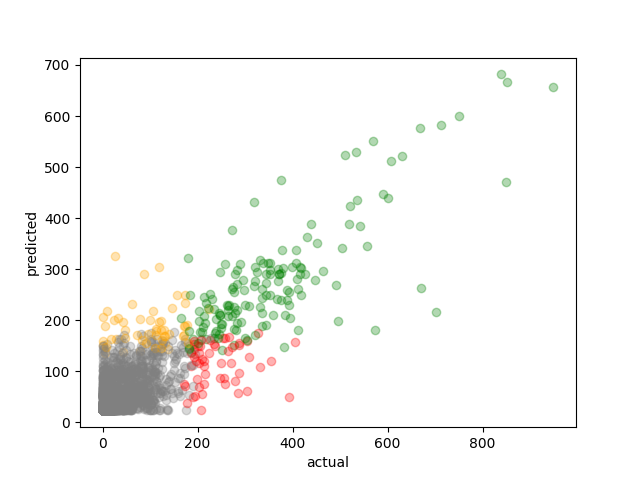

In [13]:
%matplotlib widget
fig, ax = plt.subplots(1,1)
f1_scores = []
for year in years[:-1]:
    year_data = test_train_data.loc[test_train_data['Year']==year]
    y_true = year_data['TdF'].values
    y_predict = clf.predict(year_data[data_columns])


    N = 20
    f1_scores.append(custom_f_score(y_true, y_predict, n=N, beta=2))
    tt = np.argsort(y_true)
    tp = np.argsort(y_predict)

    true_positives = np.where(np.logical_and(y_true >= y_true[tt[-N]], y_predict >= y_predict[tp[-N]]))[0]
    false_positives = np.where(np.logical_and(y_true < y_true[tt[-N]], y_predict >= y_predict[tp[-N]]))[0]
    true_negatives = np.where(np.logical_and(y_true < y_true[tt[-N]], y_predict < y_predict[tp[-N]]))[0]
    false_negatives = np.where(np.logical_and(y_true  >= y_true[tt[-N]], y_predict < y_predict[tp[-N]]))[0]

    for idx, color in zip([true_positives, false_negatives, false_positives, true_negatives], ['green', 'red', 'orange', 'grey']):
        ax.scatter(y_true[idx], y_predict[idx], alpha=0.3, color=color)
print("mean f1: ", np.mean(f1_scores))
ax.set_xlabel("actual")
ax.set_ylabel("predicted")
plt.show()

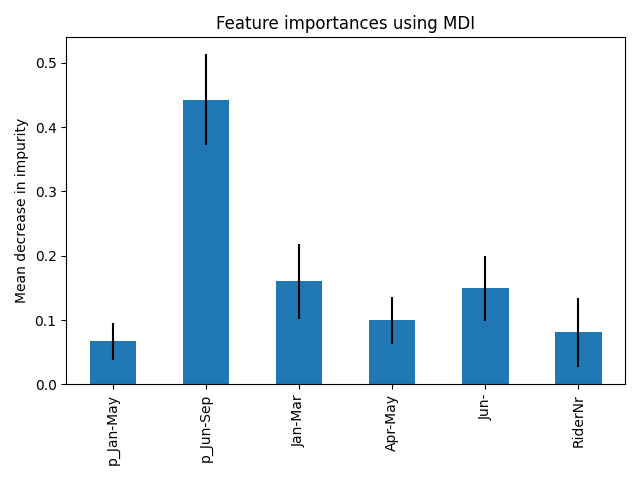

In [14]:
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)

forest_importances = pd.Series(importances, index=data_columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [15]:
test_train_data['Year'].unique()
# year_data
# year_data['prediction'] = clf.predict(year_data[data_columns])
# print(year_data.sort_values(by='prediction', ascending=False).head(30))

array([2022, 2023, 2014, 2021, 2015, 2020, 2017, 2018, 2016, 2019],
      dtype=int64)

In [16]:
all_data = data.reset_index()
tdf2024 = all_data.loc[all_data['Year']==2024]

tdf2024['Points'] = clf.predict(tdf2024[data_columns].values)

tdf2024 = tdf2024.sort_values(by='Points', ascending=False).reset_index(drop=True)
tdf2024.head(10)

c:\Users\maric\anaconda3\envs\tdf-pool\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\maric\AppData\Local\Temp\ipykernel_16092\606768204.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf2024['Points'] = clf.predict(tdf2024[data_columns].values)


,Rider,Year,BIB,Team,Jan-Mar,Apr-May,Jun-,TdF,p_Jan-May,p_Jun-Sep,RiderNr,TeamNr,Points
0,POGAČAR Tadej,2024,31,UAE Team Emirates (WT)UAE Team Emirates (WT)UA...,614.0,1201.0,0.0,0.0,558.0,1191.0,1,3,536.860044
1,VINGEGAARD Jonas,2024,21,Team Visma | Lease a Bike (WT)Team Visma | Lea...,290.0,44.0,0.0,0.0,516.0,1522.0,1,2,458.681221
2,AYUSO Juan,2024,33,UAE Team Emirates (WT)UAE Team Emirates (WT)UA...,511.0,490.0,50.0,0.0,241.0,943.0,3,3,435.543939
3,EVENEPOEL Remco,2024,91,Soudal Quick-Step (WT)Soudal Quick-Step (WT)So...,438.0,80.0,211.0,0.0,1438.0,1562.0,1,9,373.961248
4,ROGLIČ Primož,2024,101,Red Bull – BORA – hansgrohe (WT)Red Bull – BOR...,106.0,133.0,450.0,0.0,1374.0,436.0,1,1,341.459704
5,JORGENSON Matteo,2024,23,Team Visma | Lease a Bike (WT)Team Visma | Lea...,372.0,0.0,479.0,0.0,377.0,71.0,3,2,333.058853
6,ALMEIDA João,2024,32,UAE Team Emirates (WT)UAE Team Emirates (WT)UA...,177.0,0.0,404.0,0.0,1236.0,548.0,2,3,321.885860
7,GALL Felix,2024,71,Decathlon AG2R La Mondiale Team (WT)Decathlon ...,67.0,0.0,69.0,0.0,167.0,854.0,1,7,266.387585
8,PHILIPSEN Jasper,2024,126,Alpecin - Deceuninck (WT)Alpecin - Deceuninck ...,162.0,0.0,0.0,0.0,198.0,812.0,6,1,265.979557
9,YATES Adam,2024,38,UAE Team Emirates (WT)UAE Team Emirates (WT)UA...,0.0,37.0,483.0,0.0,435.0,549.0,8,3,259.739184


In [17]:
price = pd.read_csv('prices2024.csv', index_col=0).set_index('Rider')

In [32]:
tdf2024pool = tdf2024.set_index('Rider').join(price)


In [39]:
from tdf_pool.best_team import select_best_team

selection, total_points = select_best_team(tdf2024pool)

tdf2024_selection = tdf2024pool.iloc[np.where(selection)]
tdf2024_selection

INFO:tdf_pool.best_team:Finding best team of 15 riders within a total budget of 100 from a group of 176 riders


,Year,BIB,Team,Jan-Mar,Apr-May,Jun-,TdF,p_Jan-May,p_Jun-Sep,RiderNr,TeamNr,Points,Price
Rider,,,,,,,,,,,,,
AYUSO Juan,2024,33,UAE Team Emirates (WT)UAE Team Emirates (WT)UA...,511.0,490.0,50.0,0.0,241.0,943.0,3,3,435.543939,12
JORGENSON Matteo,2024,23,Team Visma | Lease a Bike (WT)Team Visma | Lea...,372.0,0.0,479.0,0.0,377.0,71.0,3,2,333.058853,11
ALMEIDA João,2024,32,UAE Team Emirates (WT)UAE Team Emirates (WT)UA...,177.0,0.0,404.0,0.0,1236.0,548.0,2,3,321.885860,8
GALL Felix,2024,71,Decathlon AG2R La Mondiale Team (WT)Decathlon ...,67.0,0.0,69.0,0.0,167.0,854.0,1,7,266.387585,8
YATES Adam,2024,38,UAE Team Emirates (WT)UAE Team Emirates (WT)UA...,0.0,37.0,483.0,0.0,435.0,549.0,8,3,259.739184,11
THOMAS Geraint,2024,57,INEOS Grenadiers (WT)INEOS Grenadiers (WT)INEO...,0.0,395.0,0.0,0.0,414.0,48.0,7,5,221.832843,10
CICCONE Giulio,2024,61,Lidl - Trek (WT)Lidl - Trek (WT)Lidl - Trek (W...,0.0,0.0,270.0,0.0,465.0,394.0,1,6,200.078969,9
MARTINEZ Lenny,2024,116,Groupama - FDJ (WT)Groupama - FDJ (WT)Groupama...,245.0,88.0,29.0,0.0,119.0,434.0,6,1,195.587204,6
CORT Magnus,2024,221,Uno-X Mobility (PRT)Uno-X Mobility (PRT)Uno-X ...,1.0,0.0,141.0,0.0,287.0,0.0,1,2,194.561301,5


In [36]:
altered_tdf2024pool = tdf2024pool.copy()
altered_tdf2024pool.loc["POGAČAR Tadej", 'Points'] += 100
altered_tdf2024pool
selection, total_points = select_best_team(altered_tdf2024pool)
altered_tdf2024pool.iloc[np.where(selection)]

INFO:tdf_pool.best_team:Finding best team of 15 riders within a total budget of 100 from a group of 176 riders


,Year,BIB,Team,Jan-Mar,Apr-May,Jun-,TdF,p_Jan-May,p_Jun-Sep,RiderNr,TeamNr,Points,Price
Rider,,,,,,,,,,,,,
AYUSO Juan,2024,33,UAE Team Emirates (WT)UAE Team Emirates (WT)UA...,511.0,490.0,50.0,0.0,241.0,943.0,3,3,435.543939,12
JORGENSON Matteo,2024,23,Team Visma | Lease a Bike (WT)Team Visma | Lea...,372.0,0.0,479.0,0.0,377.0,71.0,3,2,333.058853,11
ALMEIDA João,2024,32,UAE Team Emirates (WT)UAE Team Emirates (WT)UA...,177.0,0.0,404.0,0.0,1236.0,548.0,2,3,321.885860,8
GALL Felix,2024,71,Decathlon AG2R La Mondiale Team (WT)Decathlon ...,67.0,0.0,69.0,0.0,167.0,854.0,1,7,266.387585,8
YATES Adam,2024,38,UAE Team Emirates (WT)UAE Team Emirates (WT)UA...,0.0,37.0,483.0,0.0,435.0,549.0,8,3,259.739184,11
THOMAS Geraint,2024,57,INEOS Grenadiers (WT)INEOS Grenadiers (WT)INEO...,0.0,395.0,0.0,0.0,414.0,48.0,7,5,221.832843,10
CICCONE Giulio,2024,61,Lidl - Trek (WT)Lidl - Trek (WT)Lidl - Trek (W...,0.0,0.0,270.0,0.0,465.0,394.0,1,6,200.078969,9
MARTINEZ Lenny,2024,116,Groupama - FDJ (WT)Groupama - FDJ (WT)Groupama...,245.0,88.0,29.0,0.0,119.0,434.0,6,1,195.587204,6
CORT Magnus,2024,221,Uno-X Mobility (PRT)Uno-X Mobility (PRT)Uno-X ...,1.0,0.0,141.0,0.0,287.0,0.0,1,2,194.561301,5


In [41]:
tdf2024pool.head(30)

,Year,BIB,Team,Jan-Mar,Apr-May,Jun-,TdF,p_Jan-May,p_Jun-Sep,RiderNr,TeamNr,Points,Price
Rider,,,,,,,,,,,,,
POGAČAR Tadej,2024,31,UAE Team Emirates (WT)UAE Team Emirates (WT)UA...,614.0,1201.0,0.0,0.0,558.0,1191.0,1,3,536.860044,47
VINGEGAARD Jonas,2024,21,Team Visma | Lease a Bike (WT)Team Visma | Lea...,290.0,44.0,0.0,0.0,516.0,1522.0,1,2,458.681221,38
AYUSO Juan,2024,33,UAE Team Emirates (WT)UAE Team Emirates (WT)UA...,511.0,490.0,50.0,0.0,241.0,943.0,3,3,435.543939,12
EVENEPOEL Remco,2024,91,Soudal Quick-Step (WT)Soudal Quick-Step (WT)So...,438.0,80.0,211.0,0.0,1438.0,1562.0,1,9,373.961248,24
ROGLIČ Primož,2024,101,Red Bull – BORA – hansgrohe (WT)Red Bull – BOR...,106.0,133.0,450.0,0.0,1374.0,436.0,1,1,341.459704,25
JORGENSON Matteo,2024,23,Team Visma | Lease a Bike (WT)Team Visma | Lea...,372.0,0.0,479.0,0.0,377.0,71.0,3,2,333.058853,11
ALMEIDA João,2024,32,UAE Team Emirates (WT)UAE Team Emirates (WT)UA...,177.0,0.0,404.0,0.0,1236.0,548.0,2,3,321.885860,8
GALL Felix,2024,71,Decathlon AG2R La Mondiale Team (WT)Decathlon ...,67.0,0.0,69.0,0.0,167.0,854.0,1,7,266.387585,8
PHILIPSEN Jasper,2024,126,Alpecin - Deceuninck (WT)Alpecin - Deceuninck ...,162.0,0.0,0.0,0.0,198.0,812.0,6,1,265.979557,32
